In [42]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg

In [43]:
data_path = "data_cleaned_feature_31.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds'],
      dtype='object')


(149885, 31)

In [44]:
# drop duplicates
data = data.drop_duplicates()
data.shape

(149885, 31)

In [45]:
data.select_dtypes(include=['int64', 'float64'])

,video_view_count,video_like_count,video_comment_count,channel_view_count,channel_subscriber_count,channel_video_count,engagement_rate,video_duration_seconds
0,156272.0,4615.0,238.0,46473647,321000,207,0.031055,774.0
1,2148646.0,222346.0,11225.0,6395292,158000,61,0.108706,317.0
2,1106491.0,44317.0,2406.0,2807917957,8880000,1612,0.042226,2223.0
3,1185486.0,25373.0,2664.0,122939495,389000,635,0.023650,1297.0
4,69035.0,4346.0,125.0,85074466,436000,1429,0.064764,1269.0
...,...,...,...,...,...,...,...,...
149880,8548359.0,378107.0,3089.0,5592638348,12500000,1019,0.044593,24.0
149881,22553412.0,623924.0,7208.0,6331232520,8890000,480,0.027984,15.0
149882,63090147.0,2451904.0,3598.0,33506017412,44400000,3136,0.038921,15.0
149883,765386.0,27876.0,716.0,42201127,379000,809,0.037356,6566.0


In [46]:
def time_to_seconds(time_str):
    days, time_part = time_str.split(" days ")
    days = int(days)
    h, m, s = map(int, time_part.split(":"))
    total_seconds = days * 86400 + h * 3600 + m * 60 + s
    return total_seconds

data['time_to_trend_difference_seconds'] = data['time_difference'].apply(time_to_seconds)
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['is_weekend'] = pd.to_datetime(data['video_published_at']).dt.weekday >= 5

In [47]:
columns_for_fa = [ 'video_view_count', 'video_like_count', 'video_comment_count',
    'channel_view_count', 
    'channel_video_count', 'time_to_trend_difference_seconds',
    'video_duration_seconds']
fa_data = data[columns_for_fa].apply(pd.to_numeric, errors='coerce').dropna()
scaler = StandardScaler()
factor_data_standardized = scaler.fit_transform(fa_data)
kmo_all, kmo_model = calculate_kmo(factor_data_standardized)
print(f"KMO: {kmo_model}")
chi_square_value, p_value = calculate_bartlett_sphericity(factor_data_standardized)
print(f"Bartlett's Test - Chi-Square: {chi_square_value}, p-value: {p_value}")
fa = FactorAnalyzer(n_factors=3, rotation='varimax') 
fa.fit(factor_data_standardized)
eigenvalues, _ = fa.get_eigenvalues()
print(f"Eigenvalues: {eigenvalues}")
loadings = fa.loadings_
print(f"Factor Loadings:\n{loadings}")

KMO: 0.6110047499077821
Bartlett's Test - Chi-Square: 351240.4475798048, p-value: 0.0
Eigenvalues: [2.52114072 1.16899624 1.0289022  0.86363226 0.75901578 0.57420976
 0.08410303]
Factor Loadings:
[[ 0.8371877   0.3400273   0.04817764]
 [ 0.9575172   0.26772918  0.1195129 ]
 [ 0.50401756 -0.15539699 -0.01791814]
 [ 0.31910668  0.22810022  0.46726521]
 [-0.05170046 -0.15197509  0.35839714]
 [ 0.23732967  0.23277888 -0.16727011]
 [-0.02012567 -0.37904892  0.03271162]]


In [48]:
factor_loadings = fa.loadings_
factor_loadings

threshold = 0.4
strong_loadings = np.abs(factor_loadings) > threshold

for i in range(factor_loadings.shape[1]):  
    print(f"Factor {i+1} includes variables: {np.where(strong_loadings[:, i])[0]}")

Factor 1 includes variables: [0 1 2]
Factor 2 includes variables: []
Factor 3 includes variables: [3]


In [49]:
alpha1, ci1 = pg.cronbach_alpha(pd.DataFrame(factor_data_standardized).iloc[:, [0, 1,2]])
print(f"Factor 1 - Cronbach's Alpha: {alpha1}, 95% CI: {ci1}")

Factor 1 - Cronbach's Alpha: 0.7985978898191615, 95% CI: [0.797 0.8  ]


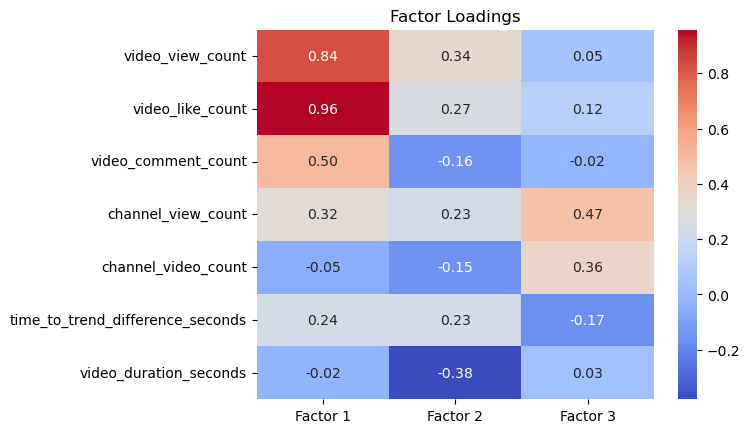

In [50]:
import seaborn as sns
factor_loadings_df = pd.DataFrame(loadings, columns=['Factor 1', 'Factor 2', 'Factor 3'], index=columns_for_fa)
sns.heatmap(factor_loadings_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Factor Loadings')
plt.show()

In [ ]:
data['is_trending'] = data['time_difference'].apply(
    lambda x: 1 if int(x.split(" ")[0]) <= 1 else 0 
)
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
0    135724
1     14161
Name: count, dtype: int64